# Surrogate Model
### Training of Feedforward Neural Network with special architecture for Ordinal Classification

In [1]:
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
import os
os.chdir("..")
from sklearn.preprocessing import StandardScaler
from src.models.ordinal_classifier_fnn import *
from src.models.coral_loss import *
from src.data.sm_dataloader import *
from src.preprocessing.sm_label_transformer import *
import torch.nn.functional as F
from sklearn.metrics import mean_absolute_error
from pickle import dump

### 1. Set seeds

In [2]:
# Set seeds in order to reproduce results
torch.manual_seed(73)
random.seed(73)
np.random.seed(73)

### 2. Load dataset

In [3]:
# Replace by true labeled dataset if available
train_dataset = DatasetSM(train=True, augmented=False, path="data/surrogate_model")
test_dataset = DatasetSM(train=False, path="data/surrogate_model")
train_dataset.X.shape

torch.Size([5309, 38])

In [4]:
train_dataset.X

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0395,  0.0514, 24.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.7143,  0.7070, 24.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.7143,  0.7786, 24.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.6105,  0.4907, 24.0000],
        [ 0.0000,  1.0000,  0.0000,  ...,  0.8615,  0.5000, 24.0000],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.6105,  0.4907, 24.0000]])

In [5]:
train_dataset.y

tensor([[1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 0.],
        ...,
        [1., 1., 1., 0.],
        [1., 1., 0., 0.],
        [0., 0., 0., 0.]])

### 3. Scale training and test data

In [6]:
scaler = StandardScaler()

# only scale numeric variables that are not one-hot encoded
scaler.fit(train_dataset.X[:, 12:])
train_dataset.scale(scaler)
test_dataset.scale(scaler)

In [40]:
#train_dataset.X
train_dataset.X[2900]

tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         8.4872e-02,  8.3550e-01,  9.0731e-02,  9.1726e-01, -2.2292e-01,
         1.0261e+00, -1.0310e+00,  3.8478e-01,  4.4583e-01,  3.7610e+00,
         9.0707e-02, -1.5281e+00, -1.1364e+00, -1.0705e+00, -8.6565e-01,
        -7.8171e-01, -9.8579e-01, -8.6640e-01, -6.1583e-01, -3.6518e-01,
        -2.7900e-01, -7.6306e-01,  2.0780e+00,  4.8552e-01, -1.5957e-01,
        -2.7360e-03, -1.3878e+00,  9.0921e-02])

In [104]:
# save fitted scaler
dump(scaler, open('models/sm_train_standard_scaler.pkl', 'wb'))

In [105]:
#  save scaled dataset
cols_X = [f'an_vec_{i}' for i in range(12)] + [f'emb_{i}' for i in range(10)] + ['_'.join(['fill', ch]) for ch in ['r','g','b']] + ['_'.join(['svg_fill', ch]) for ch in ['r','g','b']] + ['_'.join(['diff_fill', ch]) for ch in ['r','g','b']] + ['rel_height','rel_width','rel_x_position','rel_y_position','rel_x_position_to_animations','rel_y_position_to_animations','nr_paths_svg']
cols_y = [f'rating_{i}' for i in range(4)]

train_X_scaled = pd.DataFrame(train_dataset.X.numpy(), columns=cols_X)
train_y_scaled = pd.DataFrame(train_dataset.y.numpy(), columns=cols_y)
train_scaled = pd.concat([train_X_scaled, train_y_scaled], axis=1)

test_X_scaled = pd.DataFrame(test_dataset.X.numpy(), columns=cols_X)
test_y_scaled = pd.DataFrame(test_dataset.y.numpy(), columns=cols_y)
test_scaled = pd.concat([test_X_scaled, test_y_scaled], axis=1)

train_scaled.to_csv('data/surrogate_model/sm_train_data_scaled.csv', index=False)
test_scaled.to_csv('data/surrogate_model/sm_test_data_scaled.csv', index=False)

In [106]:
train_scaled.head()

,an_vec_0,an_vec_1,an_vec_2,an_vec_3,an_vec_4,an_vec_5,an_vec_6,an_vec_7,an_vec_8,an_vec_9,...,rel_width,rel_x_position,rel_y_position,rel_x_position_to_animations,rel_y_position_to_animations,nr_paths_svg,rating_0,rating_1,rating_2,rating_3
0,0.0,0.0,0.0,1.0,0.0,0.0,-1.000000,-1.000000,-1.0,-1.000000,...,-0.861189,-1.566257,-1.881579,-1.831419,-1.945342,0.035163,1.0,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,-1.000000,-1.000000,-1.0,-1.000000,...,0.618456,0.412917,0.790924,0.846977,0.939290,0.035163,1.0,1.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,-1.000000,-1.000000,-1.0,-1.000000,...,0.618456,0.412917,1.082721,0.846977,1.254249,0.035163,1.0,1.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.134364,0.847434,-1.0,-1.000000,...,-0.861189,-1.566257,-1.881579,-1.831419,-1.945342,0.035163,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,-1.000000,-1.000000,-1.0,0.763775,...,0.618456,0.412917,0.790924,0.846977,0.939290,0.035163,1.0,1.0,0.0,0.0


### 4. Upscaling of class 4/"Very Good" (optional, was shown to not improve the performance^)

In [107]:
# Get indices where data label equals 4
#label_counts = {i: len(np.where(torch.sum(train_dataset.y, axis=1) == i)[0]) for i in range(5)}
#i_class4 = np.where(torch.sum(train_dataset.y, axis=1) == 4)[0]
# Calculate upsample size (mean of class sizes 0-3 - class size 4)
#upsample_size = round(np.mean([label_counts[i] for i in range(4)])) - label_counts[4]
# Get upsample indices
#i_class4_upsampled = np.random.choice(i_class4, size=upsample_size, replace=True)

In [108]:
# Create upsampled dataframe
#train_dataset.y = torch.vstack([train_dataset.y, train_dataset.y[i_class4_upsampled]])
#train_dataset.X = torch.vstack([train_dataset.X, train_dataset.X[i_class4_upsampled]])
#train_dataset.X.shape

### 5. Train model

#### 5.1 Build model and switch to GPU if available

In [109]:
fitness_function = OrdinalClassifierFNN(num_classes=5, layer_sizes=[38,28])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
fitness_function.to(device)

cpu


OrdinalClassifierFNN(
  (hidden): ModuleList(
    (0): Linear(in_features=38, out_features=28, bias=True)
  )
  (coral_weights): Linear(in_features=28, out_features=1, bias=False)
)

In [110]:
res = fitness_function(test_dataset.X[:5])
print(res)
torch.sigmoid(res)

tensor([[ 0.6275,  0.3775,  0.1275, -0.1225],
        [ 0.6275,  0.3775,  0.1275, -0.1225],
        [ 0.5978,  0.3478,  0.0978, -0.1522],
        [ 0.6275,  0.3775,  0.1275, -0.1225],
        [ 0.5274,  0.2774,  0.0274, -0.2226]], grad_fn=<AddBackward0>)


tensor([[0.6519, 0.5933, 0.5318, 0.4694],
        [0.6519, 0.5933, 0.5318, 0.4694],
        [0.6452, 0.5861, 0.5244, 0.4620],
        [0.6519, 0.5933, 0.5318, 0.4694],
        [0.6289, 0.5689, 0.5068, 0.4446]], grad_fn=<SigmoidBackward>)

#### 5.2 Define optimizer and additional measure to report (optional)

In [111]:
#criterion = nn.L1Loss()
report_measure = nn.L1Loss()
optimizer = torch.optim.Adam(fitness_function.parameters())

#### 5.3 Define Data loaders

In [112]:
# Useful because it automatically generates batches in the training loop and takes care of shuffling

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

#### 5.4 Actual Model training

In [113]:
n_epochs = 100

# Stuff to store
train_losses = np.zeros(n_epochs)
train_bin_maes = np.zeros(n_epochs)
train_accuracies = np.zeros(n_epochs)
train_label_maes = np.zeros(n_epochs)

test_losses = np.zeros(n_epochs)
test_bin_maes = np.zeros(n_epochs)
test_accuracies = np.zeros(n_epochs)
test_label_maes = np.zeros(n_epochs)


for it in range(n_epochs):
    train_loss = []
    test_loss = []
    train_bin_mae = []
    test_bin_mae = []
    train_label_mae = []
    test_label_mae = []
    correct_train = 0
    correct_test = 0
    for inputs, targets in train_loader:
        # move data to GPU
        inputs, targets = inputs.to(device), targets.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = fitness_function(inputs)
        loss = coral_loss(outputs, targets)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Store loss and other report measures
        train_loss.append(loss.item())
        train_bin_mae.append(report_measure(torch.sigmoid(outputs), targets).item())
        train_label_mae.append(mean_absolute_error(decode_classes(targets), decode_classes(torch.sigmoid(outputs))))
        
        # Count correct predictions
        correct_train += (decode_classes(torch.sigmoid(outputs)) == decode_classes(targets)).sum()
        
    # Get train loss and test loss
    train_loss = np.mean(train_loss)
    train_bin_mae = np.mean(train_bin_mae)
    train_label_mae = np.mean(train_label_mae)
    
    # Get train accuracy
    train_accuracy = correct_train / len(train_dataset.X)
    
    predicted_classes = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = fitness_function(inputs)
        loss = coral_loss(outputs, targets)
        test_loss.append(loss.item())
        test_bin_mae.append(report_measure(torch.sigmoid(outputs), targets).item())
        test_label_mae.append(mean_absolute_error(decode_classes(targets), decode_classes(torch.sigmoid(outputs))))
        correct_test += (decode_classes(torch.sigmoid(outputs)) == decode_classes(targets)).sum()
    test_loss = np.mean(test_loss)
    test_bin_mae = np.mean(test_bin_mae)
    test_label_mae = np.mean(test_label_mae)
    test_accuracy = correct_test / len(test_dataset.X)

    # Save losses
    train_losses[it] = train_loss
    train_bin_maes[it] = train_bin_mae
    test_losses[it] = test_loss
    test_bin_maes[it] = test_bin_mae
    train_label_maes[it] = train_label_mae
    test_label_maes[it] = test_label_mae
    train_accuracies[it] = train_accuracy
    test_accuracies[it] = test_accuracy

    if (it + 1) % 10 == 0 or it==0:
        print(f'Epoch {it + 1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}'
              f' Train Binary MAE: {train_bin_mae:.4f}, Test Binary MAE: {test_bin_mae:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}, Train Label MAE:  {train_label_mae:.4f}, Test Label MAE:  {test_label_mae:.4f}')

Epoch 1/100, Train Loss: 2.5212, Test Loss: 2.4017 Train Binary MAE: 0.4588, Test Binary MAE: 0.4415, Train Accuracy: 0.2283, Test Accuracy: 0.2859, Train Label MAE:  1.3272, Test Label MAE:  1.1213
Epoch 10/100, Train Loss: 2.0259, Test Loss: 2.0652 Train Binary MAE: 0.3700, Test Binary MAE: 0.3760, Train Accuracy: 0.3950, Test Accuracy: 0.3732, Train Label MAE:  0.8490, Test Label MAE:  0.8762
Epoch 20/100, Train Loss: 1.8757, Test Loss: 1.9387 Train Binary MAE: 0.3385, Test Binary MAE: 0.3466, Train Accuracy: 0.4006, Test Accuracy: 0.3700, Train Label MAE:  0.7974, Test Label MAE:  0.8322
Epoch 30/100, Train Loss: 1.7886, Test Loss: 1.8650 Train Binary MAE: 0.3175, Test Binary MAE: 0.3267, Train Accuracy: 0.3956, Test Accuracy: 0.3708, Train Label MAE:  0.7802, Test Label MAE:  0.8189
Epoch 40/100, Train Loss: 1.7334, Test Loss: 1.8409 Train Binary MAE: 0.3025, Test Binary MAE: 0.3138, Train Accuracy: 0.3908, Test Accuracy: 0.3691, Train Label MAE:  0.7731, Test Label MAE:  0.8247
E

### 6. Evaluate model performance

#### 6.1 Compute benchmark performance values

In [114]:
unique_train, counts_train = np.unique(decode_classes(train_dataset.y).flatten(), return_counts=True)
display(len(train_dataset))
dict(zip(unique_train, counts_train))

5309

{0: 1181, 1: 1202, 2: 1511, 3: 1097, 4: 318}

In [115]:
unique_test, counts_test = np.unique(decode_classes(test_dataset.y).flatten(), return_counts=True)
display(len(test_dataset.y))
dict(zip(unique_test, counts_test))

1238

{0: 238, 1: 205, 2: 348, 3: 375, 4: 72}

In [116]:
# Accuracy for majority classifier
print(f'Test Benchmark Accuracy: {375/1238 :.4f}')

Test Benchmark Accuracy: 0.3029


In [117]:
# Label MAE for constant prediction of class 2
print(f'Test Benchmark Label MAE: {2*(238+72)/1238 + 1*(205+375)/1238 :.4f}')

Test Benchmark Label MAE: 0.9693


In [118]:
# Binary MAE for constant prediction of class 2 (1,1,0,0)
print(f'Test Benchmark Binary MAE: {(238*0.5 + 205*0.25 + 375*0.25 + 72*0.5)/1238 :.4f}')

Test Benchmark Binary MAE: 0.2423


#### 6.2 Plot the train loss and test loss per epoch

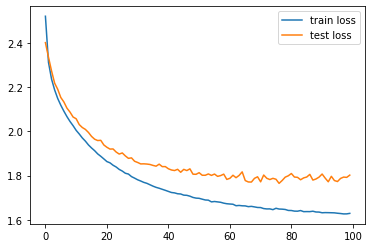

In [119]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

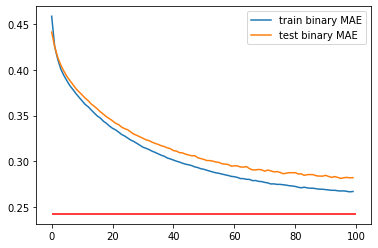

In [120]:
plt.plot(train_bin_maes, label='train binary MAE')
plt.plot(test_bin_maes, label='test binary MAE')
plt.hlines(0.2423, xmin=0, xmax=100, color='red')
plt.legend()
plt.show()

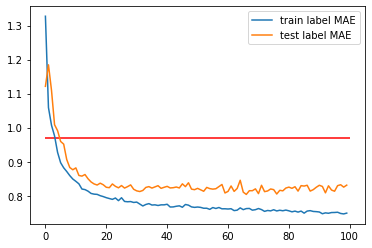

In [121]:
plt.plot(train_label_maes, label='train label MAE')
plt.plot(test_label_maes, label='test label MAE')
plt.hlines(0.9693, xmin=0, xmax=100, color='red')
plt.legend()
plt.show()

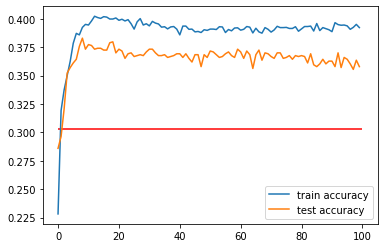

In [122]:
plt.plot(train_accuracies, label='train accuracy')
plt.plot(test_accuracies, label='test accuracy')
plt.hlines(0.3029, xmin=0, xmax=100, color='red')
plt.legend()
plt.show()

### 7. Save and load trained model

#### 7.1 Save model

In [123]:
torch.save(fitness_function.state_dict(), "models/sm_fnn.pth")

#### 7.2. Load model and make predictions

In [124]:
model = OrdinalClassifierFNN(num_classes=5, layer_sizes=[38,28])
model.load_state_dict(torch.load("models/sm_fnn.pth"))
model.eval()

OrdinalClassifierFNN(
  (hidden): ModuleList(
    (0): Linear(in_features=38, out_features=28, bias=True)
  )
  (coral_weights): Linear(in_features=28, out_features=1, bias=False)
)

In [125]:
inp = test_dataset.X[0:1]
output = model(inp)

In [126]:
output

tensor([[ 0.9084, -0.4368, -1.9579, -3.7928]], grad_fn=<AddBackward0>)

In [127]:
decode_classes(torch.sigmoid(output))[0][0]

1